## Metropolis-Hastings Background w/ Name Bradley-Terry 

Metropolis-Hastings is a sampling technique for MCMC that is often used when we start running into some problems: 

1. **Direct sampling is hard**. Continuous distributions have methods, such as the inverse CDF method or rejection sampling, that allow for direct sampling for these distributions. However, cases where the CDF doesn't have a nice close form inverse, high rejection rate, or combinatorial explosion of the state space require the need for indirect sampling. 
2. **Distributions with normalizing constants that are hard to calculate.** Metropolis-Hastings causes normalizing constants to cancel. 

In the case for Bradley-Terry, we have the case that CDF (and hence the inverse CDF) doesn't have a nice closed form and the state space combinatorially explodes (for $n$ candidates, there are $n!$ complete ballots to generate). 

In general, here's how the Metropolis-Hastings Algorithm work: 

**The Metropolis Hastings Algorithm** 

1. From state $x$, produce a new state $x'$
2. Accept the new state with acceptance ratio
$$
\alpha = \text{min}\left(1, \frac{q(x\, |\, x') \pi (x')}{q(x'\, |\, x) \pi(x)}\right)
$$
where $q( \cdot \, |\, \square)$ is the probability from transitioning from state $\square$ to $\cdot$ and $\pi(\square)$ is the probability of seeing $\square$ under the stationary distribution $\pi$. Note that $\pi$ is the distribution we want to target. 
3. Go back to step $1$ and repeat until convergence.

It's known that as long as $q$ is an irreducible transition matrix on the state space, that Metropolis-Hasting defines a reversible Markov Chain with stationary distribution $\pi.$ For our case, let's consider a MH implementation that targets the stationary distribution for name Bradley-Terry. 

Let's consider $n=3$ candidates where we have candidates $\mathcal{C} = \{A, B, C\}$ where they have preference intervals $a + b + c = 1$. Let's consider the ballot $ABC$. The probability of seeing the ballot $ABC$ under Bradley-Terry is given by 
$$
\mathbb{P}_{\text{BT}}\left( \begin{matrix}
A \\ 
B \\ 
C
\end{matrix}\right) \propto \mathbb{P}(A \prec B) \mathbb{P}(A \prec C) \mathbb{P}(B \prec C)
$$
where $I \prec J$ means that $I$ ranks higher than $J$ and its probability is given by $\mathbb{P}(I \prec J) = i / (i + j)$ where $i$ and $j$ are the respective preference intervals. Hence, the above becomes 
$$
\mathbb{P}_{\text{BT}}\left( \begin{matrix}
A \\ 
B \\ 
C
\end{matrix}\right) \propto \frac{a}{a+b} \frac{a}{a+c} \frac{b}{b+c}.
$$
Notice that this proability is proportional as it may not be the case that summing over all $3!$ probabilites equal 1. Hence, for this probability to become equality, we must have 
$$
\mathbb{P}_{\text{BT}}\left( \begin{matrix}
A \\ 
B \\ 
C
\end{matrix}\right) = \frac{1}{Z} \cdot \frac{a}{a+b} \frac{a}{a+c} \frac{b}{b+c}
$$
where $Z = \sum_{\sigma \in \Omega} \mathbb{P}_{\text{BT}}(\sigma)$ is the normalizing constant, where if we have $n$ candidates, then we will have $n!$ terms to sum and becomes computationally infeasible. Precomputing the PDF (to compute the CDF for the inverse CDF method), then becomes hard for large $n$. For large $n$, Metropolis-Hasting becomes a desirable sampling technique. 

We illustrate one example of the Metropolis-Hasting algorithm. The proposal method we use will be neighbor swaps, that is a new state/ballot is given by two adjacent ballots. Suppose our old state $x$ is given by $x = ABC$. Then we can swap $AB$ or $BC$, resulting in new ballots $x' = BCA$ or $x' = ACB$. If we pick uniformly, then we have a $1/2$ probability of each of the new ballots. This gives us the $q( \cdot\, | \, \cdot)$ probabilities. From the new state, to the old state, it holds that since our pick of proposal is uniform across the adjacent swaps that the probabilities is also $1/2$. 

For this example, suppose from ballot $ABC$ we propose the ballot $ACB$. Then, the transition probabilities from the new and old state are both $1/2$. That is to say, 
$$
\frac{q(x'\,|\,x)}{q(x\,|\,x')} = \frac{1/2}{1/2} = 1
$$
In fact, for the uniform adjacent swaps the probilities are symmetric and thus cancel. 
Next, we need to calculate the probability of seeing these ballots under Bradley-Terry. Calculating $ACB$, we have, 
$$
\mathbb{P}_{BT}\left( 
\begin{matrix}
A\\
C\\
B
\end{matrix}
\right) \propto \frac{a}{a+c} \cdot \frac{a}{a+b}\cdot \frac{c}{b+c}
$$
Then, we have 
$$
\frac{\pi(x')}{\pi(x)} = \frac{\mathbb{P}_{BT}\left( 
\begin{matrix}
A\\
C\\
B
\end{matrix}
\right)}{\mathbb{P}_{\text{BT}}\left( \begin{matrix}
A \\ 
B \\ 
C
\end{matrix}\right)} = \frac{c}{b}
$$
where the normalizing constant $Z$ canceled out with the additonal denominator of the form $(i + j)$ also canceled out as well, resulting in a quick computation of the ratio of the two preference profiles $c$ and $b$. That is to say, the acceptance ratio is given by 
$$
\alpha = \text{min}\left( 1, \frac{c}{b} \right).
$$
There are three cases to consider when we would like to accept or reject a proposal. 

*Case 1:* $\frac{c}{b} > 1$ 
Then, we always accept. This means we did a swap where we had $c > b$, meaning the candidate with the higher preference moved up. This makes intuitive sense since we are moving up a candidate with a higher preference. 

*Case 2:* $\frac{c}{b} < 1$
There is some chance of rejection. This move means we have $c < b$, meaning we placed a candidate higher where the preference was actually lower.

*Case 3:* $\frac{c}{b}=1$
Then, we always accept. We did a swap where the preference intervals were the same.


Note that the proposal of doing random neighboring swaps is not the only way to do a random walk on the ballots. Picking how to do the walk is in of itself an art. One technique we have been experimenting on doing random transpositions that need not be adjacent. Details of experiments on the performance are detailed in a later section. 

Below is a excerpt of the code where this process is outlined in Bradley-Terry. We loop through the chain length, with some neighboring swaps. The acceptance probability is exactly what we calculated above. Finally, the new proposal accepted based on what these ratios are. 

In [68]:
# generate MCMC sample
for i in range(chain_length):
    # choose adjacent pair to propose a swap
    j1, j2 = swap_indices[i]
    acceptance_prob = min(
        1,
        pref_interval[next(iter(current_ranking[j2]))]
        / pref_interval[next(iter(current_ranking[j1]))],
    )

    # if you accept, make the swap
    if random.random() < acceptance_prob:
        current_ranking[j1], current_ranking[j2] = (
            current_ranking[j2],
            current_ranking[j1],
        )
        accept += 1

NameError: name 'chain_length' is not defined

## Sample Bradley-Terry Metropolis-Hasting Runs

### Imports and Helper Functions

In [69]:
# adjust the directory so that we can import local source
import sys
import os

# Add the repo root to sys.path
ROOT_REL_PATH_FROM_NB = "../.."
repo_path = os.path.abspath(os.path.join(os.getcwd(), ROOT_REL_PATH_FROM_NB))  # adjust as needed
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

print(sys.path)

from src.votekit.ballot_generator import name_BradleyTerry 
from src.votekit.pref_interval import PreferenceInterval
from src.votekit.pref_profile import PreferenceProfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from math import factorial

['/Users/ppeaungvongpakdy/Documents/Research/votekit_bt/VoteKit', '/Users/ppeaungvongpakdy/miniforge3/lib/python312.zip', '/Users/ppeaungvongpakdy/miniforge3/lib/python3.12', '/Users/ppeaungvongpakdy/miniforge3/lib/python3.12/lib-dynload', '', '/Users/ppeaungvongpakdy/miniforge3/lib/python3.12/site-packages', '/Users/ppeaungvongpakdy/choix', '/Users/ppeaungvongpakdy/miniforge3/lib/python3.12/site-packages/setuptools/_vendor']


In [70]:
def total_variation_distance(P, Q, labels):
    sum = 0 
    for x in labels:
        sum += abs(P[x] - Q[x])
    return (1/2)*sum

def generate_BT_args(n_cands, alpha=1):
    '''
        generates arguments for name_BradleyTerry class
        with n_cands, generates single slate and single bloc.
    '''
    if n_cands == 0:
        raise Exception("cannot generate BT args for 0 candidates")

    #cands = [chr(ord('a')+i) for i in range(n_cands)] # alphabetic candidates
    cands = [f"Cand{i}" for i in range(n_cands)]
    bloc_name = "H"
    pref_interval = PreferenceInterval.from_dirichlet(candidates=cands, alpha=alpha)
    pref_intervals_by_bloc = {
        bloc_name: {
            bloc_name : pref_interval
        }
    }
    bloc_voter_prop = {bloc_name: 1}
    cohesion_paramteters = {
        bloc_name: {
            bloc_name: 1
        }
    }
    
    return {
        "candidates": cands,
        "pref_intervals_by_bloc": pref_intervals_by_bloc,
        "bloc_voter_prop" : bloc_voter_prop,
        "cohesion_parameters": cohesion_paramteters
    }

def get_pdf_from_BT_instance(bt_inst):
    '''
        Given an instance of `name_BradleyTerry` this method returns
        the bt-pdf stored on the instance
    '''
    blocs = bt_inst.blocs
    if len(blocs) != 1:
        raise Exception("Non-one bloc on bt_inst")
    return bt_inst.pdfs_by_bloc[blocs[0]]


def get_ballot_labels_and_weights(profile):
    '''
    Given a preference profile, collects the ballots and weights into
    a dictionary (Ranking as tuple : weight).
    '''
    ballot_rankings = [bal.ranking for bal in profile.ballots]
    ## convert the rankings from tuple of frozen sets into tuple of strings
    bal_labels = [tuple([list(cand)[0] for cand in ranking]) for ranking in ballot_rankings]
    bal_weights = [int(bal.weight) for bal in profile.ballots]

    return dict(zip(bal_labels, bal_weights))

In [86]:
up_to_idx = 100

In [72]:
N_CANDS_FOR_BALLOTS = 4
bt = name_BradleyTerry(**generate_BT_args(n_cands=N_CANDS_FOR_BALLOTS, alpha=1))

In [87]:
num_ballots = 500
# Generate the ballots 
ballots_arr = bt.generate_profile_MCMC_arr_ballots(num_ballots)
# Convert to Preference Profile
bals_BT_MCMC = PreferenceProfile(ballots = ballots_arr[0:up_to_idx]).group_ballots()

In [88]:
# Calculate labels 
bal_rankings_map_mcmc_as_freq = {
    ballot: weight/(up_to_idx) for ballot, weight in get_ballot_labels_and_weights(bals_BT_MCMC).items()
}

In [89]:
# populate any ballots that were not sampled
all_keys = bt_pdfs.keys()
for key in all_keys:
    bal_rankings_map_mcmc_as_freq.setdefault(key, 0)

In [90]:
cleaned_keys = [tuple(k) if isinstance(k, np.ndarray) else k for k in all_keys]

In [91]:
x_label = ["".join(ranking) for ranking in cleaned_keys]

In [92]:
bal_rankings_map_mcmc_as_freq

{('Cand3', 'Cand0', 'Cand2', 'Cand1'): 0.1,
 ('Cand3', 'Cand0', 'Cand1', 'Cand2'): 0.13,
 ('Cand3', 'Cand2', 'Cand0', 'Cand1'): 0.13,
 ('Cand3', 'Cand2', 'Cand1', 'Cand0'): 0.18,
 ('Cand3', 'Cand1', 'Cand2', 'Cand0'): 0.19,
 ('Cand3', 'Cand1', 'Cand0', 'Cand2'): 0.16,
 ('Cand2', 'Cand3', 'Cand0', 'Cand1'): 0.04,
 ('Cand2', 'Cand3', 'Cand1', 'Cand0'): 0.01,
 ('Cand1', 'Cand3', 'Cand2', 'Cand0'): 0.01,
 ('Cand1', 'Cand3', 'Cand0', 'Cand2'): 0.02,
 ('Cand0', 'Cand3', 'Cand2', 'Cand1'): 0.01,
 ('Cand0', 'Cand3', 'Cand1', 'Cand2'): 0.02,
 ('Cand0', 'Cand1', 'Cand2', 'Cand3'): 0,
 ('Cand0', 'Cand1', 'Cand3', 'Cand2'): 0,
 ('Cand0', 'Cand2', 'Cand1', 'Cand3'): 0,
 ('Cand0', 'Cand2', 'Cand3', 'Cand1'): 0,
 ('Cand1', 'Cand0', 'Cand2', 'Cand3'): 0,
 ('Cand1', 'Cand0', 'Cand3', 'Cand2'): 0,
 ('Cand1', 'Cand2', 'Cand0', 'Cand3'): 0,
 ('Cand1', 'Cand2', 'Cand3', 'Cand0'): 0,
 ('Cand2', 'Cand0', 'Cand1', 'Cand3'): 0,
 ('Cand2', 'Cand0', 'Cand3', 'Cand1'): 0,
 ('Cand2', 'Cand1', 'Cand0', 'Cand3'): 0,

Text(0, 0.5, 'Frequency')

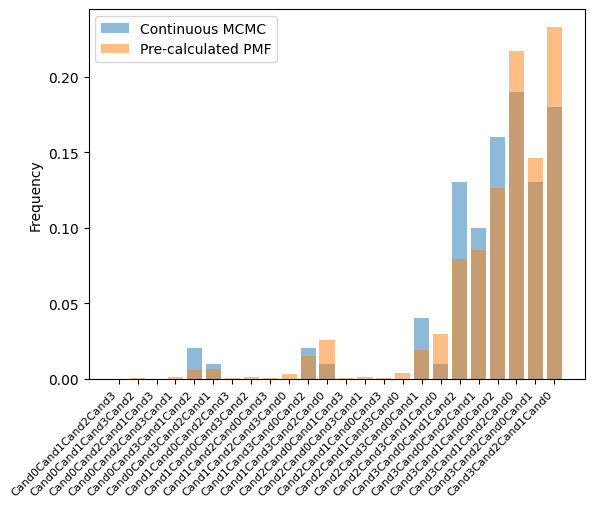

In [93]:
plt.bar(x_label, [float(bal_rankings_map_mcmc_as_freq[k]) for k in cleaned_keys], label="Continuous MCMC", alpha = 0.5)
plt.bar(x_label, [float(bt_pdfs[k]) for k in cleaned_keys], label = "Pre-calculated PMF", alpha = 0.5)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.ylabel("Frequency")

In [ ]:
bal_rankings_map_classic_as_freq = {
    ballot : weight/num_ballots for ballot, weight in get_ballot_labels_and_weights(bals_BT_classic).items()
}

In [ ]:
total_ballots = 10_000
num_ballots_array = np.linspace(100, total_ballots, 100)
num_ballots_array = num_ballots_array.astype(int)[1:]
num_trials_per_ballot_size = 10

N_CANDS_FOR_BALLOTS = 6
bt = name_BradleyTerry(**generate_BT_args(n_cands=N_CANDS_FOR_BALLOTS, alpha=1))
bt_pdfs = get_pdf_from_BT_instance(bt)

tv_distances_non_shortcut = []
tv_distances_shortcut = []
tv_distances_classic = []
for num_ballots in tqdm(num_ballots_array):
    running_total_non_shortcut = 0
    running_total_shortcut = 0
    running_total_classic = 0
    for _ in range(num_trials_per_ballot_size):
        ## -- Intialize the ballots ------------ 
        bals_BT_MCMC = bt.generate_profile_MCMC(num_ballots).group_ballots()
        bals_BT_MCMC_shortcut = bt.generate_profile_MCMC(num_ballots, on_shortcut_graph=True).group_ballots() 
        bals_BT_classic = bt.generate_profile(num_ballots).group_ballots()

        ## -- Calculate the frequencies ----------------
        bal_rankings_map_classic_as_freq = {
            ballot : weight/num_ballots for ballot, weight in get_ballot_labels_and_weights(bals_BT_classic).items()
        }
        bal_rankings_map_mcmc_as_freq = {
            ballot: weight/num_ballots for ballot, weight in get_ballot_labels_and_weights(bals_BT_MCMC).items()
        }
        bal_rankings_map_mcmc_shortcut_as_freq = {
            ballot: weight/num_ballots for ballot, weight in get_ballot_labels_and_weights(bals_BT_MCMC_shortcut).items()
        }

        # populate any ballots that were not sampled
        all_keys = bt_pdfs.keys()
        for key in all_keys:
            bal_rankings_map_classic_as_freq.setdefault(key, 0)
            bal_rankings_map_mcmc_as_freq.setdefault(key, 0)
            bal_rankings_map_mcmc_shortcut_as_freq.setdefault(key, 0)
        
        # increment the recorded tv distances
        running_total_non_shortcut += total_variation_distance(bal_rankings_map_mcmc_as_freq, bt_pdfs, list(all_keys))
        running_total_shortcut += total_variation_distance(bal_rankings_map_mcmc_shortcut_as_freq, bt_pdfs, list(all_keys))
        running_total_classic += total_variation_distance(bal_rankings_map_classic_as_freq, bt_pdfs, list(all_keys))

    tv_distances_non_shortcut.append(running_total_non_shortcut/num_trials_per_ballot_size)
    tv_distances_shortcut.append(running_total_shortcut/num_trials_per_ballot_size)
    tv_distances_classic.append(running_total_classic/num_trials_per_ballot_size)